<a href="https://colab.research.google.com/github/NyafeuKamdem/retail_demand_forcasting/blob/main/XGBoost_demand_forecast_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install darts

In [71]:
!pip install mlflow

###**Import packages**

In [70]:
# Importing the needed packages.
import numpy as np                                                # For numerical operation arraywise.
import pandas as pd                                               # For Data manipulation.
import matplotlib.pyplot as plt                                   # For basic visualization's functions.
import seaborn as sns                                             # For advance visualization's functions.
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

from darts import TimeSeries
from darts.models import ARIMA
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV

import mlflow
# Define the MLflow storage path in Google Drive
mlflow_storage_path = "/content/drive/My Drive/mlflow_favorita_results"
import joblib

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!pwd  # pwd = 'print working directory' tels us where we are

/content


In [4]:
%cd drive/MyDrive/ # cd = 'change directory'

[Errno 2] No such file or directory: 'drive/MyDrive/ # cd = change directory'
/content


In [5]:
!pwd

/content


###**Data Loading for Guayas Region**

In [92]:
df = pd.read_csv('/content/drive/MyDrive/guayas_ready.csv', index_col=0) # index_col=0 let pandas know that the df has an index

In [93]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 22285217 entries, 0 to 0
Data columns (total 12 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   id              int64  
 2   store_nbr       int64  
 3   item_nbr        int64  
 4   unit_sales      float64
 5   onpromotion     bool   
 6   z_score         float64
 7   unit_sales_log  float64
 8   year            int64  
 9   month           int64  
 10  day             int64  
 11  day_of_week     int64  
dtypes: bool(1), float64(3), int64(7), object(1)
memory usage: 2.0+ GB


In [94]:
onpromotion_onpromotion_corr =  df['onpromotion'].astype(int).corr(df['unit_sales'])
onpromotion_onpromotion_corr # if onpromotion_onpromotion_corr is closed to 0 --> onpromotion_rolling_averages probably won’t help.

np.float64(0.1364494834171825)

In [95]:
df.shape

(22285217, 12)

In [96]:
df.head(1)

,date,id,store_nbr,item_nbr,unit_sales,onpromotion,z_score,unit_sales_log,year,month,day,day_of_week
0,2013-02-17,1895433,24,96995,1.0,False,-0.728178,0.693147,2013,2,17,6


In [97]:
# Filtering the dataset for the perioid of Jan 1 – Mar 31 2014
min_date = '2013-11-30'
max_date = '2014-04-01'
df = df[(df['date'] > min_date) & (df['date'] < max_date)]
df.shape

(1266514, 12)

###**EDA**

####**Handling Missing data**

In [98]:
df.isna().sum()

,0
date,0
id,0
store_nbr,0
item_nbr,0
unit_sales,0
onpromotion,0
z_score,1
unit_sales_log,0
year,0
month,0


In [99]:
df = df.dropna(subset=['z_score'])

In [100]:
df.isna().sum()

,0
date,0
id,0
store_nbr,0
item_nbr,0
unit_sales,0
onpromotion,0
z_score,0
unit_sales_log,0
year,0
month,0


####**Feature Engineering for Machine Learning**

In [101]:
df.head(1)

,date,id,store_nbr,item_nbr,unit_sales,onpromotion,z_score,unit_sales_log,year,month,day,day_of_week
287,2013-12-01,0,24,96995,0.0,False,0.0,0.0,2013,12,1,6


In [102]:
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date').sort_index()

In [103]:
df.head(1)

,id,store_nbr,item_nbr,unit_sales,onpromotion,z_score,unit_sales_log,year,month,day,day_of_week
date,,,,,,,,,,,
2013-12-01,0,24,96995,0.0,False,0.0,0.0,2013,12,1,6


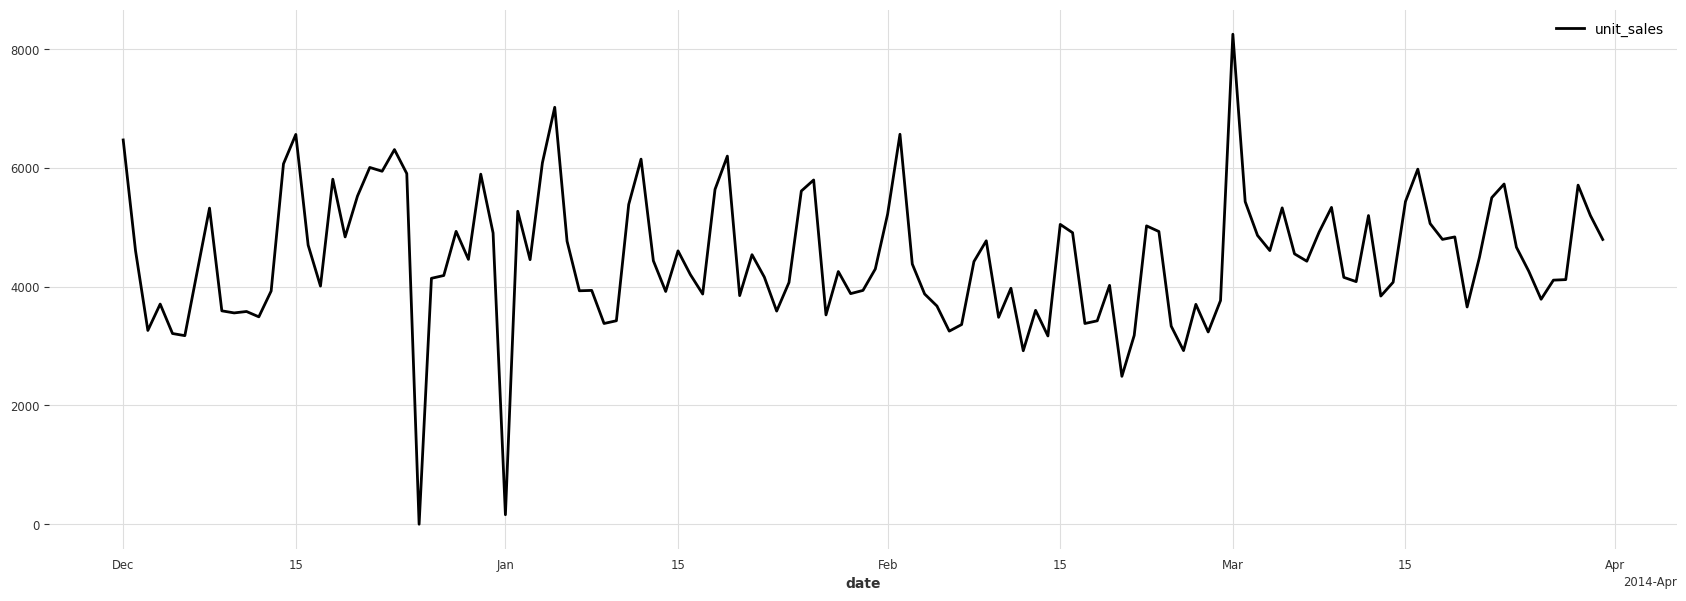

In [104]:
# Group by date and aggregate sales for each day
df_dayly = df.groupby('date').sum()['unit_sales'].reset_index()
'''
df_dayly = df.groupby('date').agg({
    'unit_sales': 'sum',        # total sales that day
    'onpromotion': 'sum',       # total number of promoted items that day
}).reset_index()
'''


# Fill missing dates with zero sales (since some dates may have no sales)
df_dayly = df_dayly.set_index('date')
df_dayly = df_dayly.asfreq('D').fillna(0)

# Convert to a Darts TimeSeries object
series = TimeSeries.from_dataframe(df_dayly, value_cols='unit_sales')

# Visualize the filtered sales data
plt.figure(figsize=(21, 7))  # Adjust the figure size (width, height)
series.plot()
plt.show()

In [105]:
# 1. Lag features (previous day, week, month)
df_dayly['lag_1'] = df_dayly['unit_sales'].shift(1)
df_dayly['lag_7'] = df_dayly['unit_sales'].shift(7)
df_dayly['lag_30'] = df_dayly['unit_sales'].shift(30)

# 2. Rolling statistics (past 7 and 30 days)
df_dayly['rolling_mean_7'] = df_dayly['unit_sales'].shift(1).rolling(window=7).mean()
df_dayly['rolling_std_7'] = df_dayly['unit_sales'].shift(1).rolling(window=7).std()
df_dayly['rolling_mean_30'] = df_dayly['unit_sales'].shift(1).rolling(window=30).mean()
df_dayly['rolling_std_30'] = df_dayly['unit_sales'].shift(1).rolling(window=30).std()

# 3. Calendar/date features
df_dayly['day'] = df_dayly.index.day
df_dayly['day_of_week'] = df_dayly.index.dayofweek
df_dayly['is_weekend'] = (df_dayly['day_of_week'] >= 5).astype(int)
df_dayly['week_of_year'] = df_dayly.index.isocalendar().week
df_dayly['month'] = df_dayly.index.month
df_dayly['is_month_start'] = df_dayly.index.is_month_start.astype(int)
df_dayly['days_from_mid'] = (df_dayly['day'] - 15).abs()
df_dayly['is_month_end'] = df_dayly.index.is_month_end.astype(int)

# 4. Drop all rows with NaN values (created by lags and rolling windows)
df_dayly = df_dayly.dropna().reset_index(drop=False)

In [106]:
df_dayly.head(2)

,date,unit_sales,lag_1,lag_7,lag_30,rolling_mean_7,rolling_std_7,rolling_mean_30,rolling_std_30,day,day_of_week,is_weekend,week_of_year,month,is_month_start,days_from_mid,is_month_end
0,2013-12-31,4905.0,5896.0,5906.0,6472.0,4218.142857,2001.392967,4582.900000,1389.795032,31,1,0,1,12,0,16,1
1,2014-01-01,160.0,4905.0,0.0,4606.0,4075.142857,1893.550935,4530.666667,1345.075010,1,2,0,1,1,1,14,0


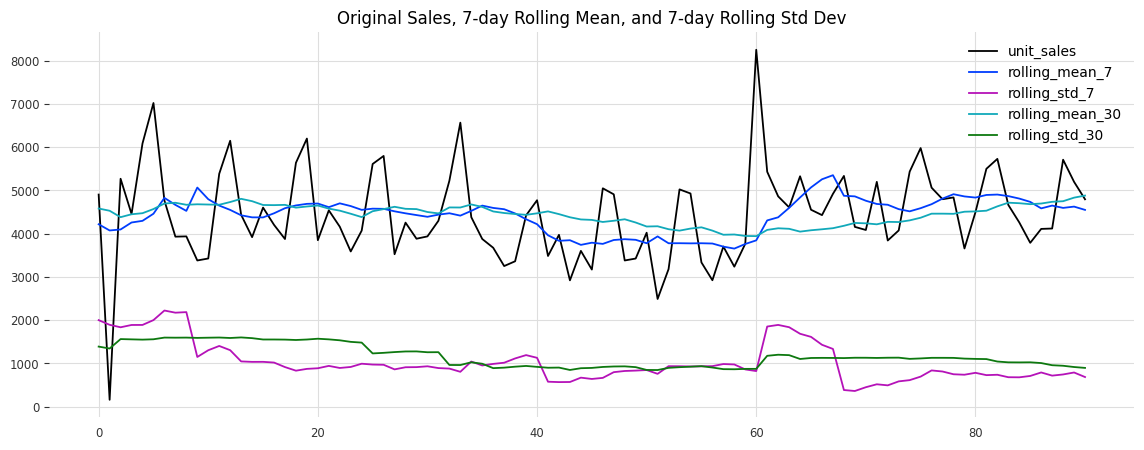

In [107]:
# Visualize the new features alongside the original sales
df_dayly[['unit_sales', 'rolling_mean_7', 'rolling_std_7', 'rolling_mean_30', 'rolling_std_30']].plot(figsize=(14, 5))
plt.title('Original Sales, 7-day Rolling Mean, and 7-day Rolling Std Dev')
plt.show()

###**Model**

####**Data Splitting**

In [108]:
df_dayly.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91 entries, 0 to 90
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   date             91 non-null     datetime64[ns]
 1   unit_sales       91 non-null     float64       
 2   lag_1            91 non-null     float64       
 3   lag_7            91 non-null     float64       
 4   lag_30           91 non-null     float64       
 5   rolling_mean_7   91 non-null     float64       
 6   rolling_std_7    91 non-null     float64       
 7   rolling_mean_30  91 non-null     float64       
 8   rolling_std_30   91 non-null     float64       
 9   day              91 non-null     int32         
 10  day_of_week      91 non-null     int32         
 11  is_weekend       91 non-null     int64         
 12  week_of_year     91 non-null     UInt32        
 13  month            91 non-null     int32         
 14  is_month_start   91 non-null     int64      

In [109]:
# Ensure the index is the date col
df_dayly = df_dayly.set_index('date', inplace=False)

# Define a min and cutoff date for training vs. testing
min_date = '2014-01-01'      #   the starting date
cutoff_date = '2014-03-01'  #   train = Jan–Feb, test = March

# Split the DataFrame chronologically
train = df_dayly[(df_dayly.index >= min_date) & (df_dayly.index < cutoff_date)]
test  = df_dayly[df_dayly.index >= cutoff_date]

# Define features and target
X_train = train.drop(['unit_sales'], axis=1)
y_train = train['unit_sales']

X_test  = test.drop('unit_sales', axis=1)
y_test  = test['unit_sales']

print("Training rows:", len(train))
print("Testing rows:", len(test))

Training rows: 59
Testing rows: 31


####**Implementing XGBoost for Time-Series Forecasting**

In [110]:
# Initialize XGBoost regressor
baseline_xgb = xgb.XGBRegressor(random_state=42)

In [111]:
# Train the XGBoost model
baseline_xgb.fit(X_train, y_train)

# Make predictions on the test set
y_pred = baseline_xgb.predict(X_test)

####**Plotting Actual vs Predicted Values and Metrics**

#####**Basic Model**

In [112]:
def actual_vs_predicted(model, name='model'):
    y_pred = model.predict(X_test)
    plt.figure(figsize=(15, 3))
    plt.plot(y_test.index, y_test.values, label='Actual Sales')
    plt.plot(y_test.index, y_pred, label='Predicted Sales', color='red')
    plt.title(f'Actual vs Predicted Sales using {name}')
    plt.legend()
    plt.show()

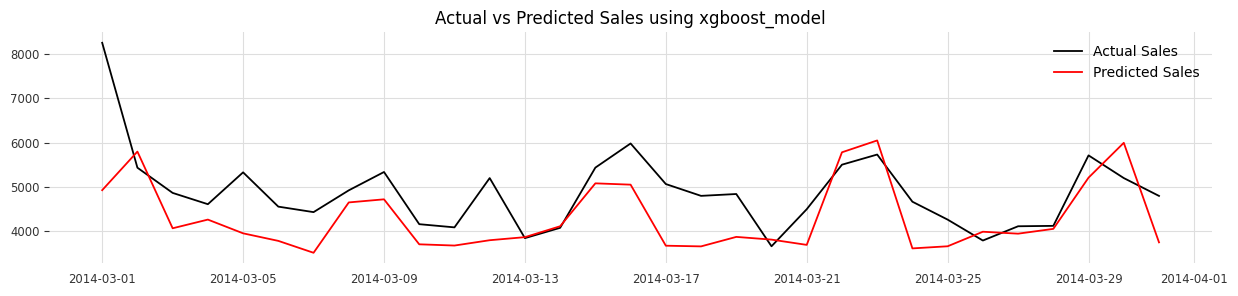

In [113]:
actual_vs_predicted(baseline_xgb, name='xgboost_model')

In [114]:
# Model Evaluation

def forecast_metrics(y_true, y_pred):
    """
    Compute a common set of forecast-error statistics.

    Parameters
    ----------
    y_true : 1-D array-like
        Actual (ground-truth) values.
    y_pred : 1-D array-like
        Forecasted values.

    Returns
    -------
    dict
        Keys: 'MAE', 'Bias', 'MAD', 'rMAD', 'MAPE', 'RMSE'
    """
    y_true = np.asarray(y_true, dtype=float).flatten()
    y_pred = np.asarray(y_pred, dtype=float).flatten()

    # basic errors
    errors       = y_true - y_pred
    abs_errors   = np.abs(errors)
    pct_errors   = abs_errors / np.where(y_true == 0, np.nan, y_true)   # avoid ÷0

    # core statistics
    mae   = abs_errors.mean()
    bias  = errors.mean()
    rmse  = np.sqrt((errors ** 2).mean())

    # MAD of the ACTUAL series (dispersion of demand itself)
    mad   = np.abs(y_true - y_true.mean()).mean()

    # Relative MAD = MAE divided by MAD  (how big the forecast error is vs. “typical” variation)
    rmad  = mae / mad if mad else np.nan

    # Mean Absolute Percentage Error
    mape  = np.nanmean(pct_errors) * 100   # expressed in %

    return {
        "MAE" : mae,
        "Bias": bias,
        "MAD" : mad,
        "rMAD": rmad,
        "MAPE": mape,
        "RMSE": rmse
    }


In [115]:
metrics = forecast_metrics(y_test, y_pred)
for k, v in metrics.items():
    print(f"{k}: {v:,.2f}")

MAE: 706.29
Bias: 566.70
MAD: 623.62
rMAD: 1.13
MAPE: 13.57
RMSE: 944.33


**MLflow**

In [116]:
# Set MLflow to log to the Google Drive directory
mlflow.set_tracking_uri(f"file:{mlflow_storage_path}")

In [117]:
# Set up experiment name
mlflow.set_experiment("baseline_xgb_vs_hypertuned_xgb")   # creates it once, reuses it next time

<Experiment: artifact_location='file:///content/drive/My Drive/mlflow_favorita_results/594154133374750405', creation_time=1755247340665, experiment_id='594154133374750405', last_update_time=1755247340665, lifecycle_stage='active', name='baseline_xgb_vs_hypertuned_xgb', tags={}>

Logging a run --> “freeze this experiment so I (and others) can review or reproduce it later.”

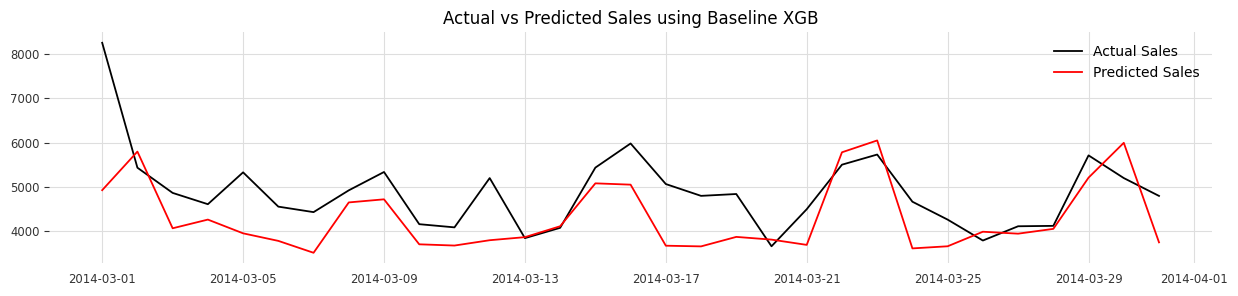

2025/08/15 09:55:47 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:1028: UserWarning: [09:55:48] WARNING: /workspace/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  self.get_booster().save_model(fname)
2025/08/15 09:55:57 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


<Figure size 640x480 with 0 Axes>

In [118]:
# Get hyperparameters from the baseline model
baseline_params = baseline_xgb.get_params()

# Save the plot to a file
plot_filename = "forecast_plot_baseline.png"
actual_vs_predicted(baseline_xgb, name='Baseline XGB')  # display the plot
plt.savefig(plot_filename)  # save it to disk

# Start MLflow run for the baseline model
with mlflow.start_run(run_name="XGBoost_Baseline"):

    # 1. Log hyperparameters
    mlflow.log_params(baseline_params)

    # 2. Log metrics
    mlflow.log_metrics(metrics)

    # 3. Log forecast plot as artifact
    mlflow.log_artifact(plot_filename)

    # 4. Log the model itself
    mlflow.xgboost.log_model(baseline_xgb, "xgboost-model-baseline")

# The run ends automatically here


#####**Hypertuned Model**

In [119]:
# Define the hyperparameter grid to search over
param_grid = {
    'n_estimators': [100, 200, 300, 500],       # Number of boosting rounds (trees)
    'max_depth': [3, 4, 5],                    # Maximum depth of each tree
    'learning_rate': [0.01, 0.1],     # Step size shrinkage for each boosting step
    'subsample': [0.8, 1.0],               # Fraction of samples used per tree
    'colsample_bytree': [0.5, 0.8]    # Fraction of features used per tree
}

tscv = TimeSeriesSplit(n_splits=5)  # split chronologically

# Initialize GridSearchCV to find the best combination of hyperparameters
grid_search = GridSearchCV(
    estimator=baseline_xgb,           # The XGBoost model to tune
    param_grid=param_grid,            # The hyperparameter grid defined above
    cv=tscv,                          # use TimeSeriesSplit(instead of standard CV) ensures that past data is used to predict future data, like in real forecasting.
    scoring='neg_mean_absolute_error',# Use negative MAE as scoring (GridSearch maximizes score)
    verbose=1                         # Print progress
)

# Fit GridSearchCV on the training data
grid_search.fit(X_train, y_train)

# Best parameters
best_params = grid_search.best_params_

# Print the best hyperparameters found
print("Best params:", grid_search.best_params_)


Fitting 5 folds for each of 96 candidates, totalling 480 fits
Best params: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100, 'subsample': 1.0}


In [120]:
# Initialize XGBoost regressor
hypertuned_xgb = xgb.XGBRegressor(
    objective='reg:squarederror',  # or use 'reg:linear' if you're on older versions
    n_estimators=best_params["n_estimators"],
    max_depth=best_params["max_depth"],
    learning_rate=best_params["learning_rate"],
    subsample=best_params["subsample"],
    colsample_bytree=best_params["colsample_bytree"],
    random_state=42
)

In [121]:
# Train the XGBoost model
hypertuned_xgb.fit(X_train, y_train)

# Make predictions on the test set
y_pred_tuned = hypertuned_xgb.predict(X_test)

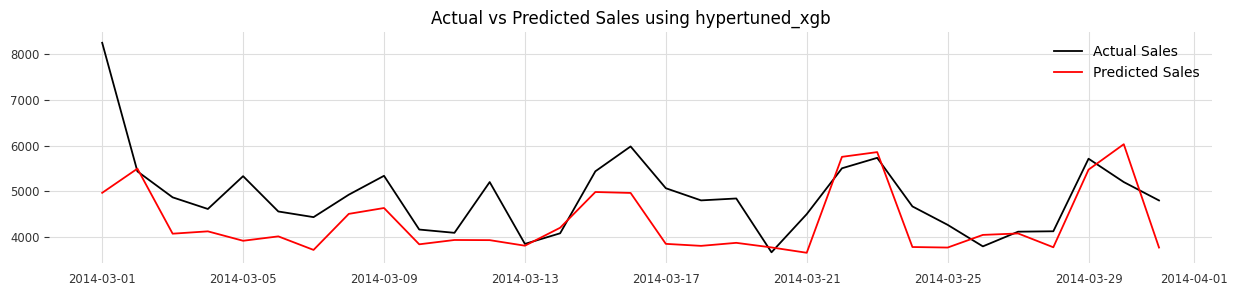

In [122]:
actual_vs_predicted(hypertuned_xgb, name='hypertuned_xgb')

In [123]:
tuned_metrics = forecast_metrics(y_test, y_pred_tuned)
for k, v in tuned_metrics.items():
    print(f"{k}: {v:,.2f}")

MAE: 660.79
Bias: 548.14
MAD: 623.62
rMAD: 1.06
MAPE: 12.65
RMSE: 906.75


**log the secon run**

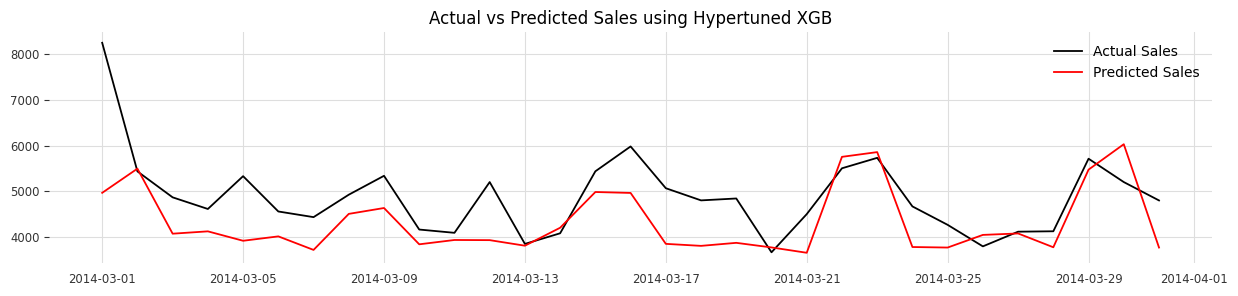

2025/08/15 09:56:37 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:1028: UserWarning: [09:56:38] WARNING: /workspace/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  self.get_booster().save_model(fname)
2025/08/15 09:56:43 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


<Figure size 640x480 with 0 Axes>

In [124]:
# Get the hyperparameters from the tuned model
tuned_params = hypertuned_xgb.get_params()

# Get the params
hyp_params = hypertuned_xgb.get_params()

# Save the plot to a file
plot_filename = "forecast_plot_tuned.png"
actual_vs_predicted(hypertuned_xgb, name='Hypertuned XGB')  # display the plot
plt.savefig(plot_filename)  # save it to disk

# Start MLflow run for the tuned model
with mlflow.start_run(run_name="XGBoost_Tuned"):

    # 1. Log hyperparameters
    mlflow.log_params(tuned_params)

    # 2. Log metrics
    mlflow.log_metrics(tuned_metrics)

    # 3. Log forecast plot as artifact
    mlflow.log_artifact(plot_filename)

    # 4. Log the model
    mlflow.xgboost.log_model(hypertuned_xgb, "xgboost-model-tuned")

# Run ends automatically


In [125]:
# 1. Save the feature columns you used
feature_columns = X_train.columns.tolist()
joblib.dump(feature_columns, "feature_columns.pkl")

print("Preprocessing artifacts saved: feature_columns.pkl")


Preprocessing artifacts saved: feature_columns.pkl
